In [1]:

import seaborn as sns
import pandas as pd
import numpy as np
import math

import os

from global_config import config
import matplotlib.pyplot as plt

results_dir = config.get_property('results_dir')


In [2]:
import numpy as np

def eakf_step(x_prior, params_prior, obs_ens_time, obs_time, oev_time, dict_params_range, num_var=8):

    prior_mean_ct = obs_ens_time.mean()
    prior_var_ct  = obs_ens_time.var()

    if prior_mean_ct == 0:
        post_var_ct  = 1e-3
        prior_var_ct = 1e-3

    post_var_ct  = prior_var_ct * oev_time / (prior_var_ct + oev_time)
    post_mean_ct = post_var_ct * (prior_mean_ct/prior_var_ct + obs_time / oev_time)
    alpha        = oev_time / (oev_time+prior_var_ct); alpha = alpha**0.5
    dy           = post_mean_ct + alpha*( obs_ens_time - prior_mean_ct ) - obs_ens_time

    # adjust parameters
    rr = []
    for idx_p, p in enumerate(dict_params_range.keys()):
        A = np.cov(params_prior[idx_p,:], obs_ens_time)
        rr.append( A[1,0] / prior_var_ct )

    rr         = np.array(rr)
    dx         = np.dot( np.expand_dims(rr,-1), np.expand_dims(dy, 0) )
    param_post = params_prior + dx

    # adjust variables
    rr = []
    for idx_var in range(num_var):
        A = np.cov(x_prior[idx_var,:], obs_ens_time)
        rr.append( A[1,0] / prior_var_ct )

    rr       = np.array(rr)
    dx       = np.dot( np.expand_dims(rr,-1), np.expand_dims(dy, 0) )
    x_post   = x_prior + dx

    obs_post    = obs_ens_time + dy

    return x_post, param_post, obs_post

def checkbound_params_old(dict_params_range, params_ens, num_ensembles=300):

    params_update = []
    for idx_p, p in enumerate(dict_params_range.keys()):
        loww = dict_params_range[p][0]
        upp  = dict_params_range[p][1]

        p_ens = params_ens[idx_p, :].copy()

        idx_wrong = np.where(np.logical_or(p_ens <loww, p_ens > upp))[0]
        idx_good  = np.where(np.logical_or(p_ens >=loww, p_ens <= upp))[0]


        p_ens[idx_wrong] = np.median(p_ens[idx_good])
        params_update.append(p_ens)

        print(f"{p}: {np.median(p_ens)}")

    return np.array(params_update)

def checkbound_params(dict_params_range, params_ens, num_ensembles=300):
    params_update = []
    for idx_p, p in enumerate(dict_params_range.keys()):
        loww = dict_params_range[p][0]
        upp  = dict_params_range[p][1]

        p_ens = params_ens[idx_p, :].copy()

        idx_wrong      = np.where(np.logical_or(p_ens <loww, p_ens > upp))[0]

        idx_wrong_loww = np.where(p_ens < loww)[0]
        idx_wrong_upp  = np.where(p_ens > upp)[0]

        idx_good  = np.where(np.logical_or(p_ens >=loww, p_ens <= upp))[0]

        p_ens[idx_wrong] = np.median(p_ens[idx_good])

        np.put(p_ens, idx_wrong_loww, loww * (1+0.2*np.random.rand( idx_wrong_loww.shape[0])) )
        np.put(p_ens, idx_wrong_upp, upp * (1-0.2*np.random.rand( idx_wrong_upp.shape[0])) )

        params_update.append(p_ens)

    return np.array(params_update)

def checkbound_state_vars(x_state_ens, pop, num_params=8, num_ensembles=300):
    loww = 0
    upp  = pop
    x_state_ens = np.clip(x_state_ens, 0, upp)
    return x_state_ens

def inflate_ensembles(ens, inflation_value=1.2, num_ensembles=300):
    return np.mean(ens,1, keepdims=True)*np.ones((1,num_ensembles)) + inflation_value*(ens-np.mean(ens,1, keepdims=True)*np.ones((1,num_ensembles)))


In [3]:
def b_transition(var, rate, dt=1):
    kb        = np.maximum(1.0 - math.exp(-rate*dt), 0)
    num_ind   = np.random.binomial(var, kb )

    return num_ind

def model(x, beta, gamma, report_rate=0.2, N=1e6):

    S   = x[0]   # Susceptibles
    I   = x[1]   # Infected Reported
    R   = x[2]   # Recovered

    foi =  beta * (I) / N

    # Stochastic transitions
    s2i     =  b_transition(S, foi)                 # susceptible to exposed
    i2r     =  b_transition(I, gamma) # exposed to infected reported who are not going to die

    # Updates
    S    = S   - s2i       # Susceptible
    I    = I   + s2i - i2r  # Infected reported
    R    = R   + i2r       # Recovered
    C    = np.random.binomial(s2i, report_rate)

    return [S, I, R, C]

In [4]:
R0    = 3
gamma = 1/7
beta  = R0*gamma
N     = 1e8

beta_truth  = beta
gamma_truth = gamma
report_rate = 0.9

num_days = 100
x  = [N-0.01*N, 0.01*N, 0, 0]

x_sol      = np.zeros((num_days, 4))

x_sol[0, :] = x
for d_idx in range(1, num_days):
    x_sol[d_idx, :] = model(x_sol[d_idx-1, :], beta, gamma, report_rate,  N)

x_sol_df = pd.DataFrame(x_sol, columns=["S", "I", "R", "C"]); x_sol_df.index.name="date"

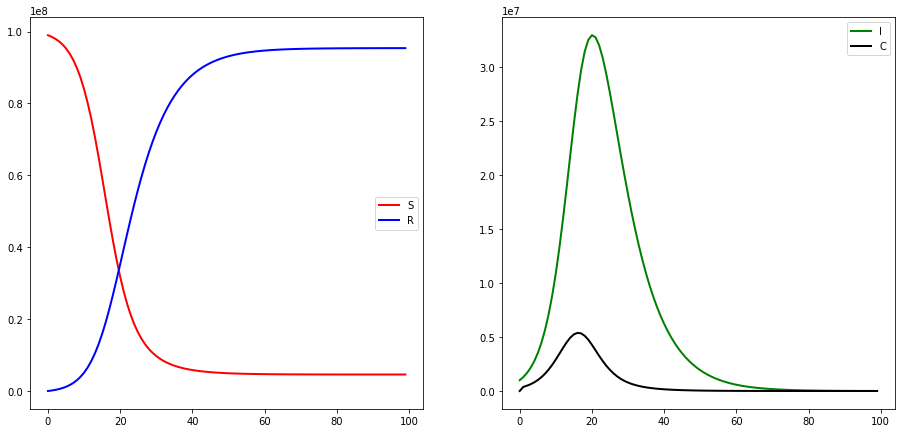

In [5]:

fig, ax = plt.subplots(1, 2, figsize=(15.5, 7.2))
ax[0].plot(x_sol_df.index.values, x_sol_df["S"], lw=2, c="r", label="S")
ax[0].plot(x_sol_df.index.values, x_sol_df["R"], lw=2, c="b", label="R")

ax[1].plot(x_sol_df.index.values, x_sol_df["I"], lw=2, c="g", label="I")
ax[1].plot(x_sol_df.index.values, x_sol_df["C"], lw=2, c="k", label="C")
ax[0].legend()
ax[1].legend()


In [6]:
from scipy.stats import truncnorm
import numpy as np


def sample_params_uniform(dict_params_range, num_ensembles=100):
    param_ens_prior = []
    for p in dict_params_range.keys():
        param_ens_prior.append( np.random.uniform( dict_params_range[p][0], dict_params_range[p][1]  , size=num_ensembles) )
    return np.array( param_ens_prior )

def get_truncated_normal(mean=0, sd=1, low=0, upp=10):
    return truncnorm( (low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd )

def sample_params_normal(dict_params_range, params_mean, params_var, num_ensembles=300):
    param_ens_prior = []
    for idx_p, p in enumerate(dict_params_range.keys()):
        norm_gen = get_truncated_normal(mean=params_mean[idx_p], sd=params_var[idx_p]**(1/2), low=dict_params_range[p][0], upp=dict_params_range[p][1])

        param_ens_prior.append( norm_gen.rvs(num_ensembles) )

    return np.array( param_ens_prior )

def create_df_response(samples, time, date_init ='2020-03-06',  quantiles = [50, 80, 95], forecast_horizon=27, dates=None, use_future=False):
    """[summary]

    Args:
        samples ([type]): [description]
        time ([type]): [description]
        date_init (str, optional): [description]. Defaults to '2020-03-06'.
        forecast_horizon (int, optional): [description]. Defaults to 27.
        use_future (bool, optional): [description]. Defaults to False.

    Returns:
        [type]: [description]
    """
    if dates is not None:
        dates_fitted = dates
    else:
        dates_fitted   = pd.date_range(start=pd.to_datetime(date_init), periods=time)
        dates_forecast = pd.date_range(start=dates_fitted[-1]+datetime.timedelta(1), periods=forecast_horizon)

    dates = list(dates_fitted)
    types = ['estimate']*len(dates_fitted)
    if use_future:
        dates += list(dates_forecast)
        types  += ['forecast']*len(dates_forecast)

    results_df = pd.DataFrame(samples.T)
    df_response = pd.DataFrame(index=dates)
    # Calculate key statistics
    df_response['mean']        = results_df.mean(axis=1).values
    df_response['median']      = results_df.median(axis=1).values
    df_response['std']         = results_df.std(axis=1).values

    for quant in quantiles:
        low_q  = ((100-quant)/2)/100
        high_q = 1-low_q

        df_response[f'low_{quant}']  = results_df.quantile(q=low_q, axis=1).values
        df_response[f'high_{quant}'] = results_df.quantile(q=high_q, axis=1).values

    df_response['type']        =  types
    df_response.index.name = 'date'

    return df_response


In [7]:
import numpy as np



def eakf_step(x_prior, params_prior, obs_ens_time, obs_time, oev_time, dict_params_range, num_var=4):

    prior_mean_ct = obs_ens_time.mean()
    prior_var_ct  = obs_ens_time.var()

    if prior_mean_ct == 0:
        post_var_ct  = 1e-3
        prior_var_ct = 1e-3


    post_var_ct  = prior_var_ct * oev_time / (prior_var_ct + oev_time)
    post_mean_ct = post_var_ct * (prior_mean_ct/prior_var_ct + obs_time / oev_time)
    alpha        = oev_time / (oev_time+prior_var_ct); alpha = alpha**0.5
    dy           = post_mean_ct + alpha*( obs_ens_time - prior_mean_ct ) - obs_ens_time

    # adjust parameters
    rr = []
    for idx_p, p in enumerate(dict_params_range.keys()):
        A = np.cov(params_prior[idx_p,:], obs_ens_time)
        rr.append( A[1,0] / prior_var_ct )

    rr         = np.array(rr)
    dx         = np.dot( np.expand_dims(rr,-1), np.expand_dims(dy, 0) )
    param_post = params_prior + dx

    # adjust variables
    rr = []
    for idx_var in range(num_var):
        A = np.cov(x_prior[idx_var,:], obs_ens_time)
        rr.append( A[1,0] / prior_var_ct )

    rr       = np.array(rr)
    dx       = np.dot( np.expand_dims(rr,-1), np.expand_dims(dy, 0) )
    x_post   = x_prior + dx

    obs_post    = obs_ens_time + dy

    return x_post, param_post, obs_post

def checkbound_params_old(dict_params_range, params_ens, num_ensembles=300):

    params_update = []
    for idx_p, p in enumerate(dict_params_range.keys()):
        loww = dict_params_range[p][0]
        upp  = dict_params_range[p][1]

        p_ens = params_ens[idx_p, :].copy()

        idx_wrong = np.where(np.logical_or(p_ens <loww, p_ens > upp))[0]
        idx_good  = np.where(np.logical_or(p_ens >=loww, p_ens <= upp))[0]


        p_ens[idx_wrong] = np.median(p_ens[idx_good])
        params_update.append(p_ens)

        print(f"{p}: {np.median(p_ens)}")

    return np.array(params_update)

def checkbound_params(dict_params_range, params_ens, num_ensembles=300):
    params_update = []
    for idx_p, p in enumerate(dict_params_range.keys()):
        loww = dict_params_range[p][0]
        upp  = dict_params_range[p][1]

        p_ens = params_ens[idx_p, :].copy()

        idx_wrong      = np.where(np.logical_or(p_ens <loww, p_ens > upp))[0]

        idx_wrong_loww = np.where(p_ens < loww)[0]
        idx_wrong_upp  = np.where(p_ens > upp)[0]

        idx_good  = np.where(np.logical_or(p_ens >=loww, p_ens <= upp))[0]

        p_ens[idx_wrong] = np.median(p_ens[idx_good])

        np.put(p_ens, idx_wrong_loww, loww * (1+0.2*np.random.rand( idx_wrong_loww.shape[0])) )
        np.put(p_ens, idx_wrong_upp, upp * (1-0.2*np.random.rand( idx_wrong_upp.shape[0])) )

        params_update.append(p_ens)

    return np.array(params_update)

def checkbound_state_vars(x_state_ens, pop, num_params=8, num_ensembles=300):
    loww = 0
    upp  = pop
    x_state_ens = np.clip(x_state_ens, 0, upp)
    return x_state_ens

def inflate_ensembles(ens, inflation_value=1.2, num_ensembles=300):
    return np.mean(ens,1, keepdims=True)*np.ones((1,num_ensembles)) + inflation_value*(ens-np.mean(ens,1, keepdims=True)*np.ones((1,num_ensembles)))


# Hints and Misc:
https://kingaa.github.io/sbied/mif/if2_settings.html



- It is generally helpful to transform the parameters so that (on the estimation scale) they are real-valued, unconstrained, and have uncertainty on the order of 1 unit. 
    - Real positive value parameters estimated on log scale.
    - Parameters in the range [0,1] estimated using a logistic transformation


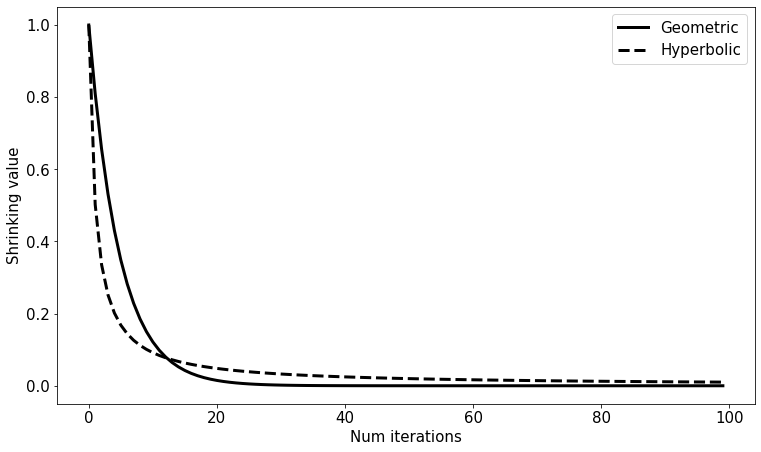

In [8]:
plt.rc('font', size=15) #controls default text size

def geometric_cooling(num_iteration_if, cooling_factor=0.9):
    alphas = cooling_factor**np.arange(num_iteration_if)
    return alphas**2

def hyperbolic_cooling(num_iteration_if, cooling_factor=0.99):
    alphas = 1/(1+cooling_factor*np.arange(num_iteration_if))
    return alphas

num_iteration_if = 100

fig, ax = plt.subplots(1, 1, figsize=(12.5, 7.3))

ax.plot(range(num_iteration_if), geometric_cooling(num_iteration_if), c="k", lw=3, label="Geometric")
ax.plot(range(num_iteration_if), hyperbolic_cooling(num_iteration_if), c="k", lw=3, label="Hyperbolic", linestyle="--")
ax.set_xlabel("Num iterations")
ax.set_ylabel("Shrinking value")
ax.legend(fontsize=15)

In [88]:

priors_range_dict  = {}
priors_range_dict["beta"]  = [0.3, 1] # Contact rate
priors_range_dict["gamma"] = [1/10, 1/3]  # Recovery rate range


lambda_inf    = 1.1
num_params    = 2
num_iters_mif = 110
alpha_mif     = 0.9 # Variance shrinking factor
num_ensembles = 300

obs_df    = x_sol_df[["C"]].rename(columns={"C": "confirmed"})

oev_df         = pd.DataFrame(columns=["date", "oev"])
oev_df["date"] = obs_df.index.values
oev_df         = oev_df.set_index("date")

oev_df["oev"] = np.maximum(20,  1+(0.2*obs_df["confirmed"].values)**2  )

######## INFERENCE  SETTINGS ########
# Range of parameters
param_range        = np.array([v for k, v in priors_range_dict.items()])
std_param          = param_range[:,1]-param_range[:,0]
SIG                = std_param ** 2 / 4; #  initial covariance of parameters

num_steps          = len(obs_df) #387
para_post_all      = np.zeros((num_params, num_ensembles, num_steps, num_iters_mif))
theta              = np.zeros((num_params, num_iters_mif+1))

confirmed_post_all = np.zeros((1, num_ensembles, num_steps, num_iters_mif))
deaths_post_all    = np.zeros((1, num_ensembles, num_steps, num_iters_mif))

para_post_all      = np.zeros((num_params, num_ensembles, num_steps, num_iters_mif))
x_post_all         = np.zeros((4, num_ensembles, num_steps, num_iters_mif))
theta              = np.zeros((num_params, num_iters_mif+1))

param_iter         = np.zeros((num_params, num_ensembles, num_iters_mif))

dates_assimilation = obs_df.index.get_level_values(0).values
dates = dates_assimilation

################################################

In [89]:
from tqdm import tqdm

print(f"Running MIF  \n")
for n in tqdm(range(num_iters_mif)):
    if n==0:
        p_prior     = sample_params_uniform(priors_range_dict, num_ensembles=num_ensembles)
        beta        = p_prior[0,:]
        gamma       = p_prior[1,:]
        x           = np.array([[N-0.01*N, 0.01*N, 0, 0.01*N]]).T * np.ones((4, num_ensembles))
        theta[:, n] = np.mean(p_prior, -1)

    else:
        params_mean     = theta[:,n]
        params_var      = SIG * (alpha_mif**n)**2
        p_prior         = sample_params_normal(priors_range_dict, params_mean, params_var, num_ensembles=num_ensembles)
        beta            = p_prior[0,:]
        gamma           = p_prior[1,:]
        x               = np.array([[N-0.01*N, 0.01*N, 0, 0.01*N]]).T * np.ones((4, num_ensembles))

    param_post_time   = np.zeros((len(priors_range_dict), num_ensembles, num_steps))
    x_post_time       = np.zeros((4, num_ensembles, num_steps))

    cases_post_time   = np.zeros((1, num_ensembles, num_steps))
    deaths_post_time  = np.zeros((1, num_ensembles, num_steps))

    idx_date_update = 0


    cases_t = np.zeros((num_ensembles, 1))
    deaths_t = np.zeros((num_ensembles, 1))

    confirmed_t = np.zeros((num_ensembles, 1))
    deaths_t    = np.zeros((num_ensembles, 1))

    for idx_t, date in enumerate(dates):

        #infalte state variables
        x = inflate_ensembles(x, inflation_value=lambda_inf, num_ensembles=num_ensembles)
        x = checkbound_state_vars(x_state_ens=x, pop=N, num_params=x.shape[0], num_ensembles=num_ensembles)

        #inflate parameters
        p_prior = inflate_ensembles(p_prior, inflation_value=lambda_inf, num_ensembles=num_ensembles)
        p_prior = checkbound_params(priors_range_dict, p_prior, num_ensembles=num_ensembles)

        x_ens =[]
        for idx_ens in range(num_ensembles):
            beta   = p_prior[0, idx_ens]
            gamma  = p_prior[1, idx_ens]

            x_ens.append(model(x[:,idx_ens], beta, gamma, report_rate, N))

        x_ens = np.array(x_ens).T
        x = x_ens

        confirmed_t  +=  np.expand_dims(x[-1,:], -1)

        if pd.to_datetime(date) == pd.to_datetime(dates_assimilation[idx_date_update]):

                oev_confirmed_time = oev_df.loc[date]["oev"]

                confirmed_time = obs_df.loc[date]["confirmed"]

                param_post = p_prior.copy()
                # Update parameters using confirmed deaths
                x_post, param_post, confirmed_obs_post = eakf_step(x, param_post, np.squeeze(confirmed_t), confirmed_time, oev_confirmed_time, priors_range_dict)
                x_post                              = checkbound_state_vars(x_state_ens=x_post, pop=N, num_params=x.shape[0], num_ensembles=num_ensembles)
                param_post                          = checkbound_params(priors_range_dict, params_ens=param_post, num_ensembles=num_ensembles)

                x = x_post
                # Use posterior and next prior
                p_prior = param_post.copy()

                cases_post_time[:,:,idx_date_update]  = confirmed_obs_post
                param_post_time[:,:,idx_date_update]  = param_post
                x_post_time[:,:,idx_date_update]      = x_post

                idx_date_update += 1

                confirmed_t = np.zeros((num_ensembles, 1))

    confirmed_post_all[:,:,:,n] = cases_post_time
    para_post_all[:,:,:,n]      = param_post_time
    param_iter[:,:,n]           = param_post_time.mean(-1)
    x_post_all[:,:,:,n]         = x_post_time
    theta[:,n+1]                = param_post_time.mean(-1).mean(-1)


  0%|          | 0/110 [00:00<?, ?it/s]

Running MIF  



100%|██████████| 110/110 [01:04<00:00,  1.70it/s]


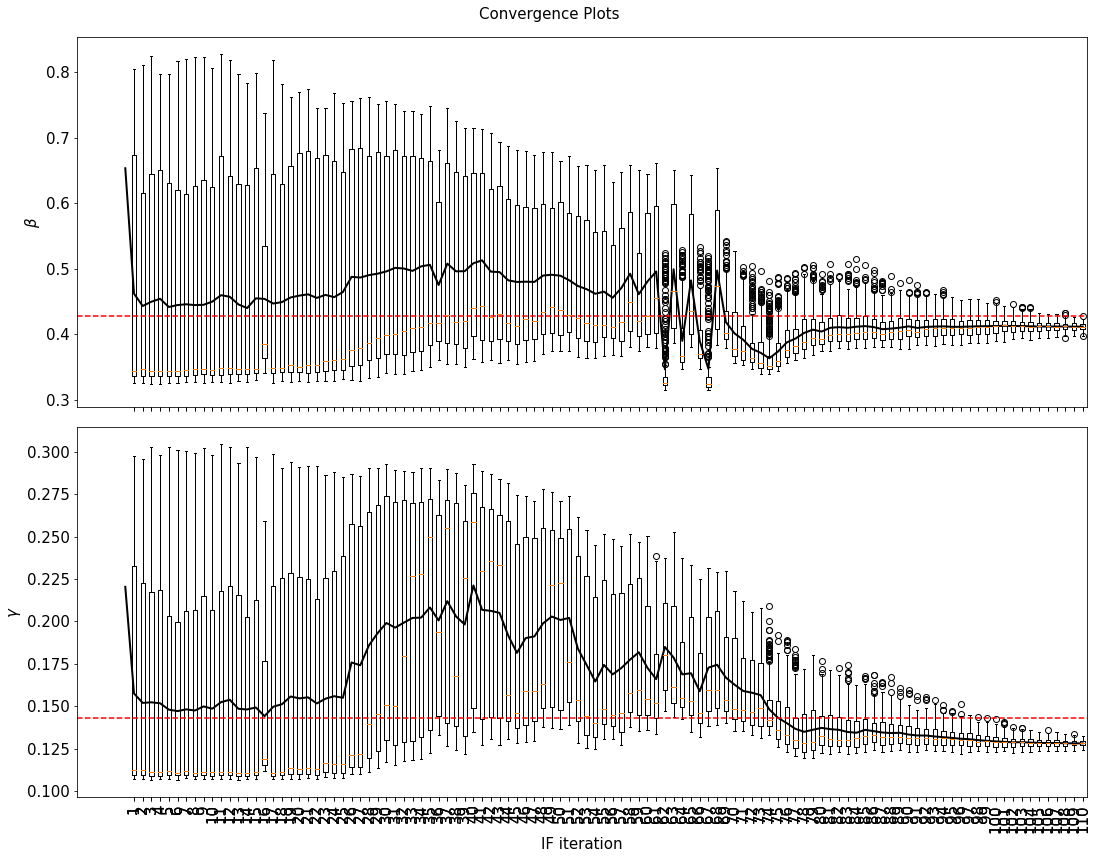

In [90]:
import seaborn as sns

# Convergence Plots
fig, ax = plt.subplots(2, 1, figsize=(15.5, 12.2), sharex=True)
ax[0].plot(range(num_iters_mif+1), theta[0,:], color="k", lw=2)
ax[0].plot(range(1,num_iters_mif+1), np.mean(param_iter[0,:,:], -2), color="r", lw=2)
#ax[0].plot(range(1,num_iters_mif+1), np.median(param_iter[0,:,:], -2), color="blue", lw=2)
ax[0].boxplot(param_iter[0,:,:])

ax[0].axhline(y=beta_truth, color="red", linestyle="--")

ax[1].plot(range(num_iters_mif+1), theta[1,:], color="k", lw=2)
#ax[1].plot(range(1,num_iters_mif+1), np.mean(param_iter[1,:,:], -2), color="r", lw=2)
#ax[1].plot(range(1,num_iters_mif+1), np.median(param_iter[1,:,:], -2), color="blue", lw=2)
ax[1].boxplot(param_iter[1, :, :])

ax[1].axhline(y=gamma_truth, color="red", linestyle="--")

ax[0].set_ylabel(r"$\beta$", fontsize=15)
ax[1].set_ylabel(r"$\gamma$", fontsize=15)

for axi in ax:
    axi.tick_params( which='both', axis='both', labelsize=15)
    axi.tick_params( which='both', axis='x', labelrotation=90, labelsize=15)

ax[1].set_xlabel("IF iteration", fontsize=15)
fig.suptitle("Convergence Plots", fontsize=15)
plt.tight_layout()

fig.savefig(os.path.join(results_dir, "eakf_convergence_plot_IF1.png"), dpi=300, transparent=True)


Text(0.5, 39.7, 'Date')

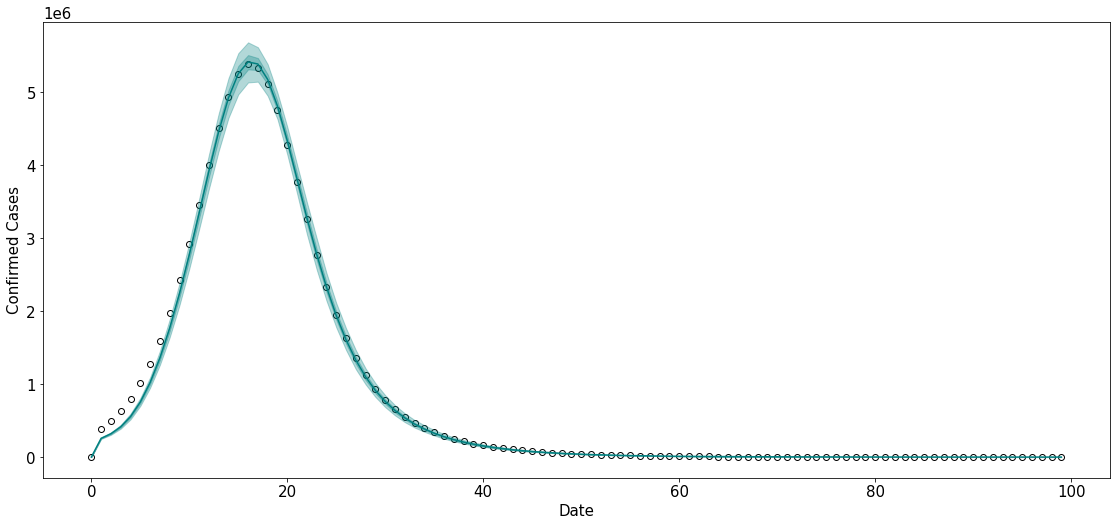

In [13]:
import datetime

confirmed_time_fitted = np.mean(confirmed_post_all[:,:,:,9:20],-1)
df_confirmed          = create_df_response(np.squeeze(confirmed_time_fitted), time=num_steps)

fig, ax = plt.subplots(1, 1, figsize=(15.5, 7.3))

ax.scatter(obs_df.index.values, obs_df.confirmed, facecolor="white", edgecolor="k")
ax.plot(obs_df.index.values[:num_steps], df_confirmed["mean"], color="teal")
ax.fill_between(obs_df.index.values[:num_steps], df_confirmed["low_95"], df_confirmed["high_95"], color="teal", alpha=0.3)
ax.fill_between(obs_df.index.values[:num_steps], df_confirmed["low_50"], df_confirmed["high_50"], color="teal", alpha=0.3)
plt.tight_layout()

ax.set_ylabel("Confirmed Cases", fontsize=15)
ax.set_xlabel("Date", fontsize=15)


# Iterated Filtering 2

## Inference for dynamic and latent variable models via iterated, perturbed Bayes maps
    Edward L. Ionidesa, Dao Nguyena, Yves Atchadéa, Stilian Stoeva, and Aaron A. King (2015)

From: https://github.com/kingaa/pomp/blob/master/R/mif2.R

##' At each iteration, the particle filter is performed on a perturbed version of the model, in which the parameters to be estimated are subjected to random perturbations at each observation.

##' This extra variability effectively smooths the likelihood surface and combats particle depletion by introducing diversity into particle population.

##' As the iterations progress, the magnitude of the perturbations is diminished according to a user-specified cooling schedule.



In [14]:
# The only difference with the previous IF is that in each time step parameters are resampled from the specified covariance matrix

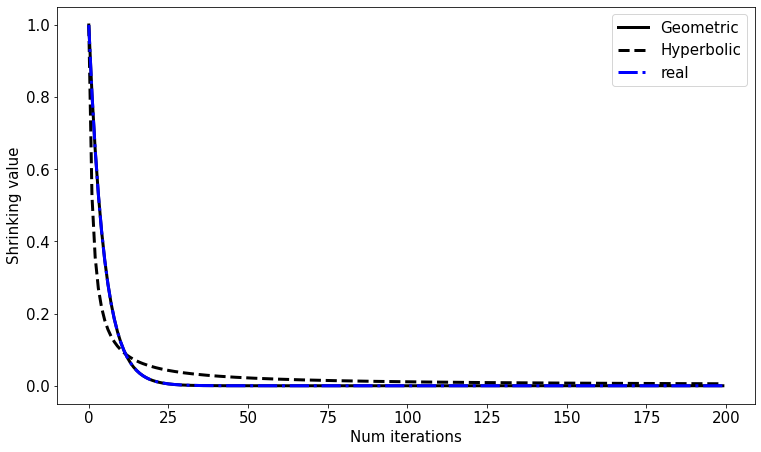

In [15]:
params_var = []
for n in range(num_iters_mif):
    params_var.append((alpha_mif**n)**2)

fig, ax = plt.subplots(1, 1, figsize=(12.5, 7.3))

ax.plot(range(num_iters_mif), geometric_cooling(num_iters_mif, alpha_mif), c="k", lw=3, label="Geometric")
ax.plot(range(num_iters_mif), hyperbolic_cooling(num_iters_mif, alpha_mif), c="k", lw=3, label="Hyperbolic", linestyle="--")
ax.plot(range(num_iters_mif), params_var, c="blue", lw=3, label="real", linestyle="-.")

ax.set_xlabel("Num iterations")
ax.set_ylabel("Shrinking value")
ax.legend(fontsize=15)

In [83]:

priors_range_dict  = {}
priors_range_dict["beta"]  = [0.2, 1.5] # Contact rate
priors_range_dict["gamma"] = [1/10, 1/3]  # Recovery rate range


lambda_inf    = 1.01
num_params    = 2
num_iters_mif = 200
alpha_mif     = 0.9 # Variance shrinking factor
num_ensembles = 200

obs_df    = x_sol_df[["C"]].rename(columns={"C": "confirmed"})

oev_df         = pd.DataFrame(columns=["date", "oev"])
oev_df["date"] = obs_df.index.values
oev_df         = oev_df.set_index("date")

oev_df["oev"] = np.maximum(20,  1+(0.2*obs_df["confirmed"].values)**2  )

######## INFERENCE  SETTINGS ########
# Range of parameters
param_range        = np.array([v for k, v in priors_range_dict.items()])
std_param          = param_range[:,1]-param_range[:,0]
SIG                = std_param ** 2 / 4; #  initial covariance of parameters

num_steps          = len(obs_df) #387

confirmed_post_all = np.zeros((1, num_ensembles, num_steps, num_iters_mif))
deaths_post_all    = np.zeros((1, num_ensembles, num_steps, num_iters_mif))

para_post_all      = np.zeros((num_params, num_ensembles, num_steps, num_iters_mif))
x_post_all         = np.zeros((4, num_ensembles, num_steps, num_iters_mif))
theta              = np.zeros((num_params, num_iters_mif+1))
theta_time         = np.zeros((num_params, num_steps+2, num_iters_mif+1))

param_iter         = np.zeros((num_params, num_ensembles, num_iters_mif))

dates_assimilation = obs_df.index.get_level_values(0).values
dates = dates_assimilation

################################################

In [84]:

shrinking_variance      = geometric_cooling(num_iters_mif, 0.9)
shrinking_variance_time = hyperbolic_cooling(num_iters_mif, 0.9)

from tqdm import tqdm
print(f"Running MIF  \n")
for n in tqdm(range(num_iters_mif)):
    if n==0:
        p_prior     = sample_params_uniform(priors_range_dict, num_ensembles=num_ensembles)
        beta        = p_prior[0,:]
        gamma       = p_prior[1,:]
        x           = np.array([[N-0.01*N, 0.01*N, 0, 0.01*N]]).T * np.ones((4, num_ensembles))
        theta[:, n]       = np.mean(p_prior, -1)
        theta_time[:,0,n] = np.mean(p_prior, -1)


    else:
        params_mean       = theta[:,n]
        params_var        = SIG * shrinking_variance[n]
        p_prior           = sample_params_normal(priors_range_dict, params_mean, params_var, num_ensembles=num_ensembles)
        beta              = p_prior[0,:]
        gamma             = p_prior[1,:]
        x                 = np.array([[N-0.01*N, 0.01*N, 0, 0.01*N]]).T * np.ones((4, num_ensembles))
        theta_time[:,0,n] = np.mean(p_prior, -1)

    param_post_time   = np.zeros((len(priors_range_dict), num_ensembles, num_steps))
    x_post_time       = np.zeros((4, num_ensembles, num_steps))

    cases_post_time   = np.zeros((1, num_ensembles, num_steps))
    deaths_post_time  = np.zeros((1, num_ensembles, num_steps))

    idx_date_update = 0


    confirmed_t = np.zeros((num_ensembles, 1))
    deaths_t    = np.zeros((num_ensembles, 1))

    for idx_t, date in enumerate(dates[:100]):
        #infalte state variables
        x = inflate_ensembles(x, inflation_value=lambda_inf, num_ensembles=num_ensembles)
        x = checkbound_state_vars(x_state_ens=x, pop=N, num_params=x.shape[0], num_ensembles=num_ensembles)

        # Perturbate parameters
        if idx_t>0:
            p_prior = sample_params_normal(priors_range_dict, p_prior.mean(-1), SIG * shrinking_variance[n], num_ensembles=num_ensembles)

        #inflate parameters
        p_prior = inflate_ensembles(p_prior, inflation_value=lambda_inf, num_ensembles=num_ensembles)
        p_prior = checkbound_params(priors_range_dict, p_prior, num_ensembles=num_ensembles)

        x_ens   = []
        for idx_ens in range(num_ensembles):
            beta   = p_prior[0, idx_ens]
            gamma  = p_prior[1, idx_ens]

            x_ens.append(model(x[:,idx_ens], beta, gamma, report_rate, N))

        x_ens = np.array(x_ens).T
        x = x_ens

        confirmed_t  +=  np.expand_dims(x[-1,:], -1)

        if pd.to_datetime(date) == pd.to_datetime(dates_assimilation[idx_date_update]):

                oev_confirmed_time = oev_df.loc[date]["oev"]
                confirmed_time     = obs_df.loc[date]["confirmed"]

                param_post = p_prior.copy()
                # Update parameters using confirmed deaths
                x_post, param_post, confirmed_obs_post = eakf_step(x, param_post, np.squeeze(confirmed_t), confirmed_time, oev_confirmed_time, priors_range_dict)
                x_post                                 = checkbound_state_vars(x_state_ens=x_post, pop=N, num_params=x.shape[0], num_ensembles=num_ensembles)
                param_post                             = checkbound_params(priors_range_dict, params_ens=param_post, num_ensembles=num_ensembles)

                x = x_post.copy()

                # Use posterior as next prior
                p_prior = param_post.copy()

                cases_post_time[:,:,idx_date_update]  = confirmed_obs_post
                param_post_time[:,:,idx_date_update]  = param_post
                x_post_time[:,:,idx_date_update]      = x_post

                idx_date_update += 1
                theta_time[:,idx_date_update,n]       = param_post.mean(-1) # average over ensemble members

                confirmed_t = np.zeros((num_ensembles, 1))

    confirmed_post_all[:,:,:,n] = cases_post_time
    para_post_all[:,:,:,n]      = param_post_time
    param_iter[:,:,n]           = param_post_time.mean(-1) # average over time
    x_post_all[:,:,:,n]         = x_post_time
    theta[:,n+1]                = param_iter[:,:,n].mean(-1)


  0%|          | 0/200 [00:00<?, ?it/s]

Running MIF  



100%|██████████| 200/200 [02:09<00:00,  1.54it/s]


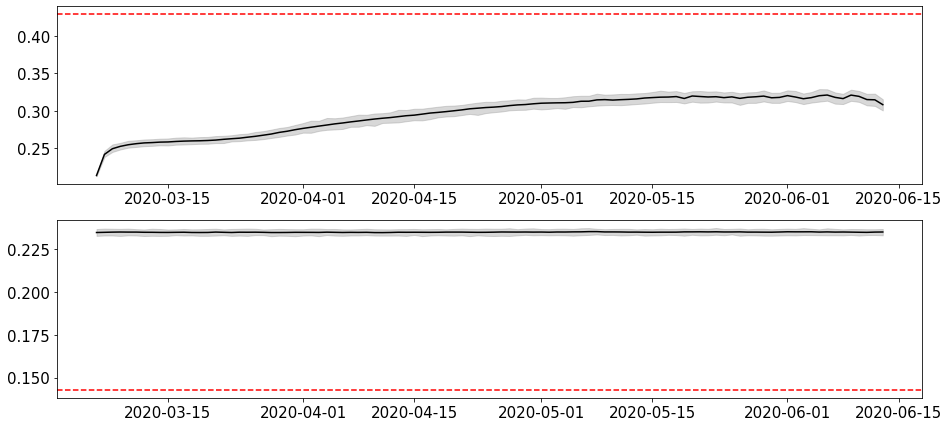

In [85]:
para_post_timesss = para_post_all.mean(-1)
beta_time  = para_post_timesss[0,:,:]
gamma_time = para_post_timesss[1,:,:]


beta_time_df   = create_df_response(beta_time, time=100)
gamma_time_df  = create_df_response(gamma_time, time=100)


fig, ax= plt.subplots(2, 1, figsize=(15.5, 7.2))

ax[0].plot(beta_time_df.index.values, beta_time_df["mean"], c="k")
ax[0].fill_between(beta_time_df.index.values, beta_time_df["low_95"],  beta_time_df["high_95"], color="gray", alpha=0.3)
ax[0].axhline(y=beta_truth, color="red", linestyle="--")

ax[1].plot(gamma_time_df.index.values, gamma_time_df["mean"], c="k")
ax[1].fill_between(gamma_time_df.index.values, gamma_time_df["low_95"],  gamma_time_df["high_95"], color="gray", alpha=0.3)
ax[1].axhline(y=gamma_truth, color="red", linestyle="--")


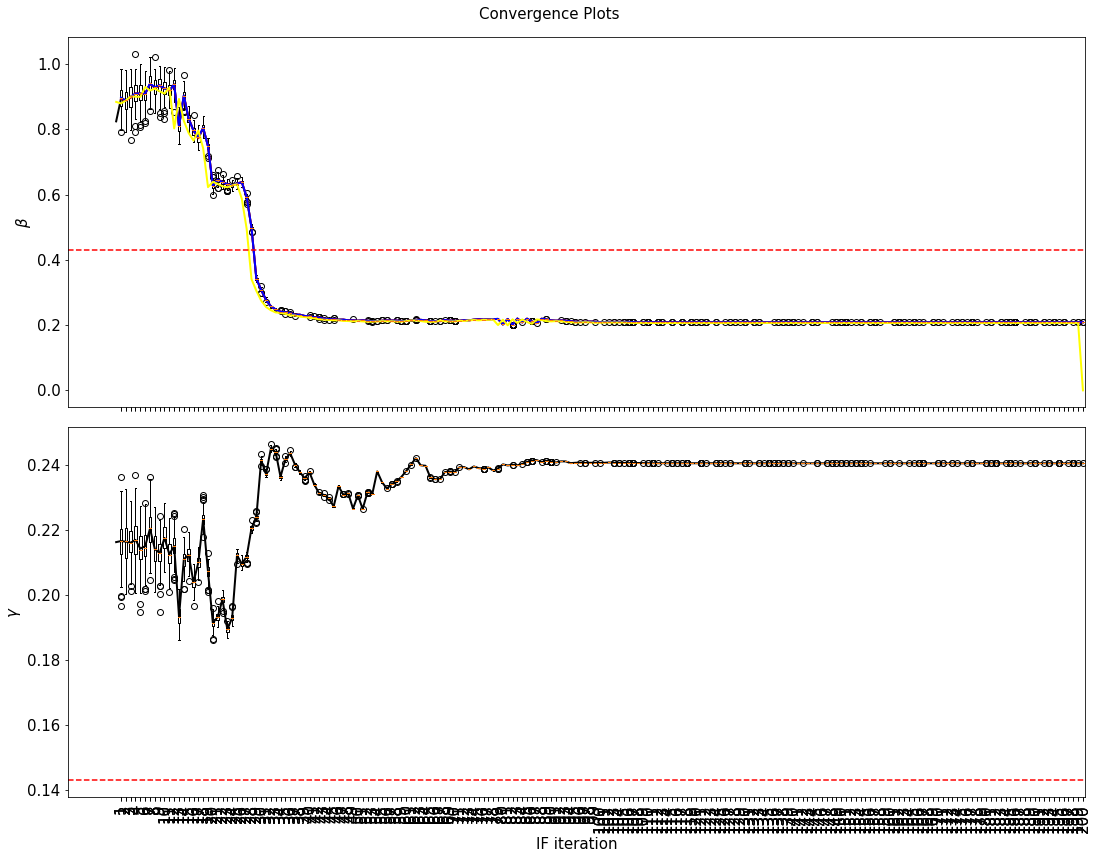

In [86]:
import seaborn as sns

aja = para_post_all.mean(-2)

# Convergence Plots
fig, ax = plt.subplots(2, 1, figsize=(15.5, 12.2), sharex=True)
ax[0].boxplot(aja[0,:,:])
ax[0].plot(range(num_iters_mif+1), theta[0,:], color="k", lw=2)
ax[0].plot(range(1,num_iters_mif+1), np.mean(param_iter[0,:,:], -2), color="r", lw=2)
ax[0].plot(range(1,num_iters_mif+1), np.median(param_iter[0,:,:], -2), color="blue", lw=2)

ax[0].plot(range(num_iters_mif+1), theta_time.mean(-2)[0], color="yellow", lw=2)

ax[0].axhline(y=beta_truth, color="red", linestyle="--")

ax[1].boxplot(aja[1, :, :])
ax[1].plot(range(num_iters_mif+1), theta[1,:], color="k", lw=2)
#ax[1].plot(range(1,num_iters_mif+1), np.mean(param_iter[1,:,:], -2), color="r", lw=2)
#ax[1].plot(range(1,num_iters_mif+1), np.median(param_iter[1,:,:], -2), color="blue", lw=2)

ax[1].axhline(y=gamma_truth, color="red", linestyle="--")

ax[0].set_ylabel(r"$\beta$", fontsize=15)
ax[1].set_ylabel(r"$\gamma$", fontsize=15)

for axi in ax:
    axi.tick_params( which='both', axis='both', labelsize=15)
    axi.tick_params( which='both', axis='x', labelrotation=90, labelsize=15)

ax[1].set_xlabel("IF iteration", fontsize=15)
fig.suptitle("Convergence Plots", fontsize=15)
plt.tight_layout()



Text(0.5, 39.7, 'Date')

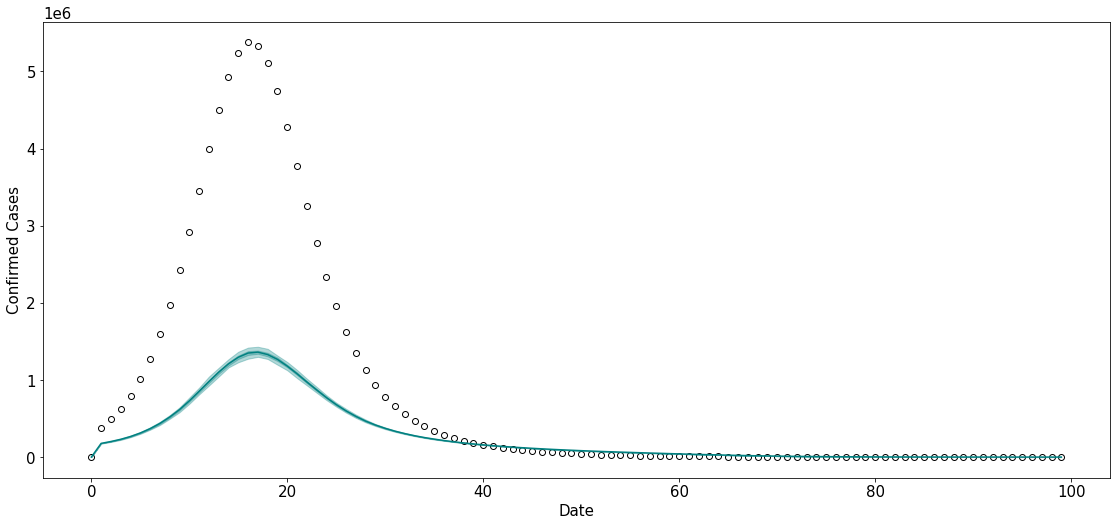

In [87]:
import datetime

confirmed_time_fitted = np.mean(confirmed_post_all[:,:,:,9:100],-1)
df_confirmed          = create_df_response(np.squeeze(confirmed_time_fitted), time=num_steps)

fig, ax = plt.subplots(1, 1, figsize=(15.5, 7.3))

ax.scatter(obs_df.index.values, obs_df.confirmed, facecolor="white", edgecolor="k")
ax.plot(obs_df.index.values[:num_steps], df_confirmed["mean"], color="teal")
ax.fill_between(obs_df.index.values[:num_steps], df_confirmed["low_95"], df_confirmed["high_95"], color="teal", alpha=0.3)
ax.fill_between(obs_df.index.values[:num_steps], df_confirmed["low_50"], df_confirmed["high_50"], color="teal", alpha=0.3)
plt.tight_layout()

ax.set_ylabel("Confirmed Cases", fontsize=15)
ax.set_xlabel("Date", fontsize=15)
